In [1]:
pwd

'/home/sn/EVA7/Eva7_Weights_Heist/S13'

In [ ]:
## Cats&Dogs Data is from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
# Download train.zip and test.zip files from the above site to the notebook folder

In [8]:
#pip install ipywidgets

     |████████████████████████████████| 121 kB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 10.7 MB/s eta 0:00:01


Note: you may need to restart the kernel to use updated packages.


In [2]:
#pip install vit-pytorch linformer

     |████████████████████████████████| 50 kB 3.7 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Train Data: 25000
Test Data: 12500


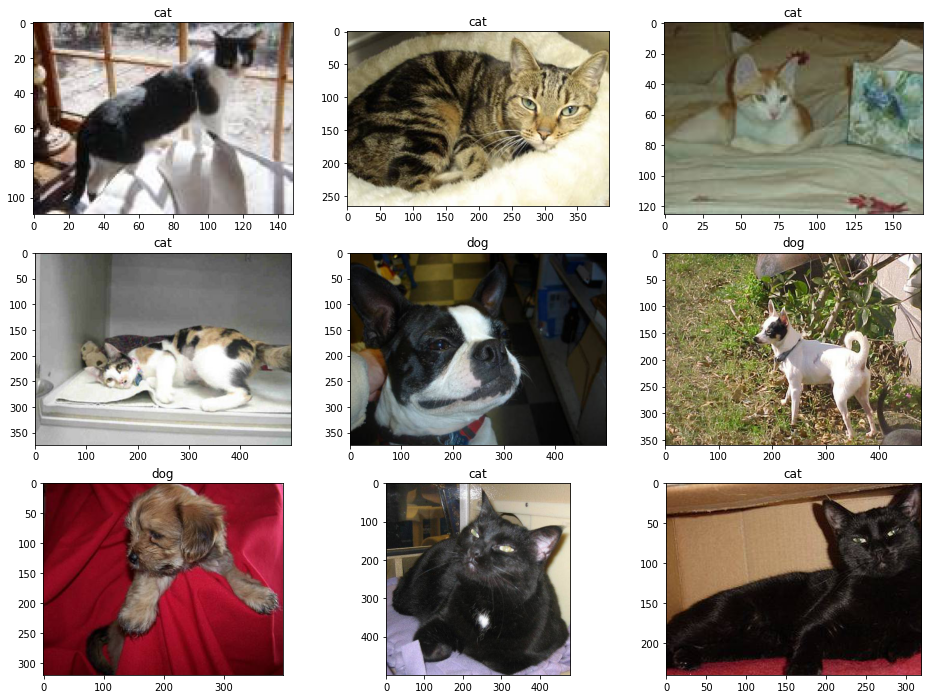

In [2]:

# loading Libraries

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   

# import Linformer

from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
#from tqdm.notebook import tqdm
from tqdm import tqdm
from __future__ import print_function

# import torch and related libraries 

import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

#to unzip the datasets
import zipfile   

#sklearn to split the data

from sklearn.model_selection import train_test_split  

#definining batch size, epocs, learning rate and gamma for training  

batch_size = 256 #64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

#Load data

os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

#Unzipping dataset
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

#Defining labels

labels = [path.split('/')[-1].split('.')[0] for path in train_list]

# printing few images 

random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [3]:
#Splitting train and validation list
seed = 2020

train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

# Torch transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

#Loading dataset for training 

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

#defining train, validation and test dataset

train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

#loading dataloader

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [4]:
#Line transformer 
device = 'cuda'

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

#Visual transformer 

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

# loss function

criterion = nn.CrossEntropyLoss()

# optimizer

optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [5]:
#start training

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader, total=len(train_loader)):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 1 - loss : 0.6942 - acc: 0.5031 - val_loss : 0.6937 - val_acc: 0.5009



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 2 - loss : 0.6939 - acc: 0.5115 - val_loss : 0.7020 - val_acc: 0.4986



100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch : 3 - loss : 0.6935 - acc: 0.5163 - val_loss : 0.6895 - val_acc: 0.5429



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 4 - loss : 0.6910 - acc: 0.5270 - val_loss : 0.6866 - val_acc: 0.5626



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 5 - loss : 0.6847 - acc: 0.5551 - val_loss : 0.6872 - val_acc: 0.5440



100%|██████████| 79/79 [01:24<00:00,  1.07s/it]


Epoch : 6 - loss : 0.6818 - acc: 0.5608 - val_loss : 0.6780 - val_acc: 0.5668



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 7 - loss : 0.6761 - acc: 0.5755 - val_loss : 0.6758 - val_acc: 0.5668



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 8 - loss : 0.6747 - acc: 0.5748 - val_loss : 0.6706 - val_acc: 0.5823



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 9 - loss : 0.6716 - acc: 0.5778 - val_loss : 0.6660 - val_acc: 0.5889



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 10 - loss : 0.6696 - acc: 0.5813 - val_loss : 0.6644 - val_acc: 0.5869



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 11 - loss : 0.6660 - acc: 0.5831 - val_loss : 0.6683 - val_acc: 0.5837



100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch : 12 - loss : 0.6616 - acc: 0.5928 - val_loss : 0.6645 - val_acc: 0.5804



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 13 - loss : 0.6540 - acc: 0.6013 - val_loss : 0.6771 - val_acc: 0.5791



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 14 - loss : 0.6563 - acc: 0.6020 - val_loss : 0.6581 - val_acc: 0.5969



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 15 - loss : 0.6525 - acc: 0.6070 - val_loss : 0.6522 - val_acc: 0.6040



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 16 - loss : 0.6460 - acc: 0.6154 - val_loss : 0.6441 - val_acc: 0.6290



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 17 - loss : 0.6425 - acc: 0.6198 - val_loss : 0.6463 - val_acc: 0.6091



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 18 - loss : 0.6381 - acc: 0.6279 - val_loss : 0.6486 - val_acc: 0.6154



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 19 - loss : 0.6344 - acc: 0.6280 - val_loss : 0.6371 - val_acc: 0.6278



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 20 - loss : 0.6311 - acc: 0.6352 - val_loss : 0.6296 - val_acc: 0.6451



In [6]:
#start training

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader, total=len(train_loader)):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

100%|██████████| 79/79 [01:23<00:00,  1.06s/it]


Epoch : 1 - loss : 0.6251 - acc: 0.6400 - val_loss : 0.6341 - val_acc: 0.6301



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 2 - loss : 0.6225 - acc: 0.6464 - val_loss : 0.6299 - val_acc: 0.6402



100%|██████████| 79/79 [01:22<00:00,  1.05s/it]


Epoch : 3 - loss : 0.6240 - acc: 0.6437 - val_loss : 0.6255 - val_acc: 0.6506



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 4 - loss : 0.6178 - acc: 0.6478 - val_loss : 0.6212 - val_acc: 0.6464



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 5 - loss : 0.6141 - acc: 0.6576 - val_loss : 0.6168 - val_acc: 0.6484



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 6 - loss : 0.6107 - acc: 0.6617 - val_loss : 0.6125 - val_acc: 0.6528



100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch : 7 - loss : 0.6096 - acc: 0.6622 - val_loss : 0.6204 - val_acc: 0.6403



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 8 - loss : 0.6106 - acc: 0.6558 - val_loss : 0.6048 - val_acc: 0.6662



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 9 - loss : 0.6093 - acc: 0.6575 - val_loss : 0.6022 - val_acc: 0.6635



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 10 - loss : 0.6055 - acc: 0.6654 - val_loss : 0.6034 - val_acc: 0.6584



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 11 - loss : 0.6037 - acc: 0.6631 - val_loss : 0.6040 - val_acc: 0.6635



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 12 - loss : 0.5984 - acc: 0.6721 - val_loss : 0.6041 - val_acc: 0.6621



100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch : 13 - loss : 0.6015 - acc: 0.6667 - val_loss : 0.5990 - val_acc: 0.6703



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 14 - loss : 0.5971 - acc: 0.6737 - val_loss : 0.5911 - val_acc: 0.6745



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 15 - loss : 0.5956 - acc: 0.6746 - val_loss : 0.6090 - val_acc: 0.6628



100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch : 16 - loss : 0.5919 - acc: 0.6767 - val_loss : 0.5961 - val_acc: 0.6752



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 17 - loss : 0.5938 - acc: 0.6770 - val_loss : 0.5956 - val_acc: 0.6737



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 18 - loss : 0.5902 - acc: 0.6767 - val_loss : 0.5985 - val_acc: 0.6786



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 19 - loss : 0.5894 - acc: 0.6760 - val_loss : 0.5922 - val_acc: 0.6864



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 20 - loss : 0.5861 - acc: 0.6835 - val_loss : 0.5912 - val_acc: 0.6793



In [7]:
#start training
epochs = 75

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader, total=len(train_loader)):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 1 - loss : 0.5879 - acc: 0.6773 - val_loss : 0.5870 - val_acc: 0.6853



100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch : 2 - loss : 0.5884 - acc: 0.6826 - val_loss : 0.5892 - val_acc: 0.6721



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 3 - loss : 0.5890 - acc: 0.6793 - val_loss : 0.5849 - val_acc: 0.6821



100%|██████████| 79/79 [01:22<00:00,  1.05s/it]


Epoch : 4 - loss : 0.5832 - acc: 0.6867 - val_loss : 0.5871 - val_acc: 0.6794



100%|██████████| 79/79 [01:22<00:00,  1.05s/it]


Epoch : 5 - loss : 0.5847 - acc: 0.6847 - val_loss : 0.5855 - val_acc: 0.6808



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 6 - loss : 0.5810 - acc: 0.6899 - val_loss : 0.5911 - val_acc: 0.6801



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 7 - loss : 0.5821 - acc: 0.6856 - val_loss : 0.5820 - val_acc: 0.6945



100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch : 8 - loss : 0.5805 - acc: 0.6865 - val_loss : 0.5738 - val_acc: 0.6965



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 9 - loss : 0.5835 - acc: 0.6885 - val_loss : 0.5810 - val_acc: 0.6898



100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch : 10 - loss : 0.5760 - acc: 0.6907 - val_loss : 0.5808 - val_acc: 0.6938



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 11 - loss : 0.5769 - acc: 0.6911 - val_loss : 0.5804 - val_acc: 0.6874



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 12 - loss : 0.5778 - acc: 0.6920 - val_loss : 0.5775 - val_acc: 0.6934



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 13 - loss : 0.5733 - acc: 0.6937 - val_loss : 0.5760 - val_acc: 0.6908



100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch : 14 - loss : 0.5764 - acc: 0.6939 - val_loss : 0.5780 - val_acc: 0.6923



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 15 - loss : 0.5718 - acc: 0.6974 - val_loss : 0.5759 - val_acc: 0.6906



100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch : 16 - loss : 0.5704 - acc: 0.6934 - val_loss : 0.5931 - val_acc: 0.6808



100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch : 17 - loss : 0.5743 - acc: 0.6947 - val_loss : 0.5742 - val_acc: 0.6963



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 18 - loss : 0.5734 - acc: 0.6938 - val_loss : 0.5750 - val_acc: 0.7027



100%|██████████| 79/79 [01:22<00:00,  1.05s/it]


Epoch : 19 - loss : 0.5750 - acc: 0.6944 - val_loss : 0.5701 - val_acc: 0.6924



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 20 - loss : 0.5768 - acc: 0.6909 - val_loss : 0.5734 - val_acc: 0.6912



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 21 - loss : 0.5690 - acc: 0.7003 - val_loss : 0.5734 - val_acc: 0.6868



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 22 - loss : 0.5717 - acc: 0.6940 - val_loss : 0.5717 - val_acc: 0.6955



100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch : 23 - loss : 0.5679 - acc: 0.6978 - val_loss : 0.5650 - val_acc: 0.7058



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 24 - loss : 0.5652 - acc: 0.7016 - val_loss : 0.5655 - val_acc: 0.7016



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 25 - loss : 0.5652 - acc: 0.7022 - val_loss : 0.5627 - val_acc: 0.7026



100%|██████████| 79/79 [01:23<00:00,  1.05s/it]


Epoch : 26 - loss : 0.5658 - acc: 0.7004 - val_loss : 0.5646 - val_acc: 0.7033



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 27 - loss : 0.5651 - acc: 0.7009 - val_loss : 0.5628 - val_acc: 0.7031



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 28 - loss : 0.5639 - acc: 0.7047 - val_loss : 0.5668 - val_acc: 0.7050



100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch : 29 - loss : 0.5664 - acc: 0.6981 - val_loss : 0.5713 - val_acc: 0.6967



100%|██████████| 79/79 [01:22<00:00,  1.05s/it]


Epoch : 30 - loss : 0.5604 - acc: 0.7055 - val_loss : 0.5648 - val_acc: 0.6998



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 31 - loss : 0.5651 - acc: 0.6985 - val_loss : 0.5618 - val_acc: 0.7079



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 32 - loss : 0.5635 - acc: 0.7050 - val_loss : 0.5665 - val_acc: 0.7016



100%|██████████| 79/79 [01:22<00:00,  1.05s/it]


Epoch : 33 - loss : 0.5644 - acc: 0.7028 - val_loss : 0.5630 - val_acc: 0.7029



100%|██████████| 79/79 [01:22<00:00,  1.05s/it]


Epoch : 34 - loss : 0.5652 - acc: 0.7040 - val_loss : 0.5662 - val_acc: 0.7043



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 35 - loss : 0.5637 - acc: 0.7044 - val_loss : 0.5651 - val_acc: 0.7027



100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch : 36 - loss : 0.5647 - acc: 0.7049 - val_loss : 0.5639 - val_acc: 0.7066



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 37 - loss : 0.5564 - acc: 0.7110 - val_loss : 0.5778 - val_acc: 0.6938



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 38 - loss : 0.5613 - acc: 0.7010 - val_loss : 0.5690 - val_acc: 0.7029



100%|██████████| 79/79 [01:20<00:00,  1.03s/it]


Epoch : 39 - loss : 0.5592 - acc: 0.7094 - val_loss : 0.5633 - val_acc: 0.7052



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 40 - loss : 0.5594 - acc: 0.7107 - val_loss : 0.5535 - val_acc: 0.7123



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 41 - loss : 0.5534 - acc: 0.7121 - val_loss : 0.5555 - val_acc: 0.7098



100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch : 42 - loss : 0.5586 - acc: 0.7085 - val_loss : 0.5499 - val_acc: 0.7150



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 43 - loss : 0.5541 - acc: 0.7108 - val_loss : 0.5553 - val_acc: 0.7125



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 44 - loss : 0.5493 - acc: 0.7148 - val_loss : 0.5616 - val_acc: 0.7048



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 45 - loss : 0.5546 - acc: 0.7095 - val_loss : 0.5578 - val_acc: 0.7126



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 46 - loss : 0.5583 - acc: 0.7081 - val_loss : 0.5488 - val_acc: 0.7173



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 47 - loss : 0.5617 - acc: 0.7069 - val_loss : 0.5553 - val_acc: 0.7102



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 48 - loss : 0.5575 - acc: 0.7034 - val_loss : 0.5625 - val_acc: 0.7021



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 49 - loss : 0.5523 - acc: 0.7161 - val_loss : 0.5618 - val_acc: 0.7112



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 50 - loss : 0.5512 - acc: 0.7143 - val_loss : 0.5617 - val_acc: 0.7043



100%|██████████| 79/79 [01:22<00:00,  1.05s/it]


Epoch : 51 - loss : 0.5585 - acc: 0.7055 - val_loss : 0.5570 - val_acc: 0.7113



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 52 - loss : 0.5452 - acc: 0.7170 - val_loss : 0.5591 - val_acc: 0.7084



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 53 - loss : 0.5492 - acc: 0.7171 - val_loss : 0.5629 - val_acc: 0.7126



100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch : 54 - loss : 0.5502 - acc: 0.7160 - val_loss : 0.5611 - val_acc: 0.7034



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 55 - loss : 0.5444 - acc: 0.7176 - val_loss : 0.5509 - val_acc: 0.7132



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 56 - loss : 0.5525 - acc: 0.7134 - val_loss : 0.5446 - val_acc: 0.7227



100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch : 57 - loss : 0.5459 - acc: 0.7174 - val_loss : 0.5486 - val_acc: 0.7197



100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch : 58 - loss : 0.5443 - acc: 0.7241 - val_loss : 0.5491 - val_acc: 0.7142



100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch : 59 - loss : 0.5503 - acc: 0.7140 - val_loss : 0.5645 - val_acc: 0.7124



100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch : 60 - loss : 0.5511 - acc: 0.7157 - val_loss : 0.5549 - val_acc: 0.7198



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 61 - loss : 0.5459 - acc: 0.7188 - val_loss : 0.5573 - val_acc: 0.7132



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 62 - loss : 0.5501 - acc: 0.7115 - val_loss : 0.5530 - val_acc: 0.7139



100%|██████████| 79/79 [01:23<00:00,  1.05s/it]


Epoch : 63 - loss : 0.5465 - acc: 0.7143 - val_loss : 0.5492 - val_acc: 0.7140



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 64 - loss : 0.5447 - acc: 0.7222 - val_loss : 0.5511 - val_acc: 0.7094



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 65 - loss : 0.5485 - acc: 0.7193 - val_loss : 0.5568 - val_acc: 0.7173



100%|██████████| 79/79 [01:22<00:00,  1.05s/it]


Epoch : 66 - loss : 0.5442 - acc: 0.7157 - val_loss : 0.5462 - val_acc: 0.7234



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 67 - loss : 0.5479 - acc: 0.7186 - val_loss : 0.5529 - val_acc: 0.7182



100%|██████████| 79/79 [01:22<00:00,  1.05s/it]


Epoch : 68 - loss : 0.5447 - acc: 0.7186 - val_loss : 0.5425 - val_acc: 0.7214



100%|██████████| 79/79 [01:22<00:00,  1.04s/it]


Epoch : 69 - loss : 0.5382 - acc: 0.7265 - val_loss : 0.5623 - val_acc: 0.7047



100%|██████████| 79/79 [01:22<00:00,  1.05s/it]


Epoch : 70 - loss : 0.5458 - acc: 0.7207 - val_loss : 0.5541 - val_acc: 0.7153



100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch : 71 - loss : 0.5448 - acc: 0.7196 - val_loss : 0.5478 - val_acc: 0.7212



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 72 - loss : 0.5439 - acc: 0.7182 - val_loss : 0.5437 - val_acc: 0.7253



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 73 - loss : 0.5437 - acc: 0.7176 - val_loss : 0.5567 - val_acc: 0.7117



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 74 - loss : 0.5409 - acc: 0.7190 - val_loss : 0.5449 - val_acc: 0.7243



100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch : 75 - loss : 0.5399 - acc: 0.7201 - val_loss : 0.5457 - val_acc: 0.7178

